In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.formula.api import ols
from statsmodels.graphics.regressionplots import plot_partregress_grid
from priceloop_api.utils import DefaultConfiguration, read_nocode, to_nocode

In [2]:
"""
This is a Demo account, usually you should not git your username/password
but store in a .env file. In the future, we will provide API keys instead
of username/password
"""
configuration = DefaultConfiguration.with_user_credentials("nocode_ml_demo@priceloop.ai", "a9r*Gjh*RKmAua")

In [3]:
# load data from our nocode platform
category_data = read_nocode("cafe___sell_meta_data", configuration, limit=20, offset=0)
transactions_data = read_nocode("cafe___transaction___store", configuration, limit=6000, offset=0)

In [4]:
category_data

,SELL_ID,SELL_CATEGORY,ITEM_ID,ITEM_NAME,COSTS,MIN_PRICE,MAX_PRICE
0,1070,0,7821,BURGER,8.0,9.6,24.6
1,3055,0,3052,COFFEE,1.0,1.2,16.2
2,3067,0,5030,COKE,3.0,3.6,18.6
3,3028,0,6249,LEMONADE,2.0,2.4,17.4
4,2051,2,7821,BURGER,6.0,7.2,22.2
5,2051,2,5030,COKE,8.0,9.6,24.6
6,2052,2,7821,BURGER,6.0,7.2,22.2
7,2052,2,6249,LEMONADE,7.0,8.4,23.4
8,2053,2,7821,BURGER,7.0,8.4,23.4
9,2053,2,5030,COKE,8.0,9.6,24.6


In [5]:
transactions_data.head()

,STORE,CALENDAR_DATE,PRICE,QUANTITY,SELL_ID,SELL_CATEGORY
0,1,1/1/12,15.50,46,1070,0
1,1,1/1/12,12.73,22,2051,2
2,1,1/1/12,12.75,18,2052,2
3,1,1/1/12,12.60,30,2053,2
4,1,1/2/12,15.50,70,1070,0


In [6]:
# check for null values and also duplicates
transactions_data[transactions_data.isnull().any(axis=1)]

,STORE,CALENDAR_DATE,PRICE,QUANTITY,SELL_ID,SELL_CATEGORY


In [7]:
transactions_data[transactions_data.duplicated()]

,STORE,CALENDAR_DATE,PRICE,QUANTITY,SELL_ID,SELL_CATEGORY
1704,1,3/1/13,15.50,90,1070,0
1710,1,3/1/13,13.41,40,2052,2
1711,1,3/1/13,13.41,40,2053,2


In [8]:
# remove duplicates
transactions_data = transactions_data.drop_duplicates()

In [9]:
# merge category data with sales data
data = pd.merge(category_data, transactions_data.drop(columns=["SELL_CATEGORY"]), on="SELL_ID")

In [10]:
data.head()

,SELL_ID,SELL_CATEGORY,ITEM_ID,ITEM_NAME,COSTS,MIN_PRICE,MAX_PRICE,STORE,CALENDAR_DATE,PRICE,QUANTITY
0,1070,0,7821,BURGER,8.0,9.6,24.6,1,1/1/12,15.5,46
1,1070,0,7821,BURGER,8.0,9.6,24.6,1,1/2/12,15.5,70
2,1070,0,7821,BURGER,8.0,9.6,24.6,1,1/3/12,15.5,62
3,1070,0,7821,BURGER,8.0,9.6,24.6,1,1/4/12,15.5,88
4,1070,0,7821,BURGER,8.0,9.6,24.6,1,1/5/12,15.5,104


In [11]:
# need to group it as we have multiples transactions per day for each SELL_ID
cleaned_data = data.groupby(["SELL_ID", "SELL_CATEGORY", "ITEM_NAME", "CALENDAR_DATE", "PRICE", "COSTS"]).QUANTITY.sum()
cleaned_data = cleaned_data.reset_index()

## Find model elasticity for one SELL_ID first, in this case we take "1070"

In [12]:
burger_1070 = cleaned_data[cleaned_data["SELL_ID"] == 1070]

In [13]:
burger_1070_model = ols("QUANTITY ~ PRICE", data=burger_1070).fit()

In [14]:
# we can see that elasticity is around -7, the R-squared is pretty low
# this is a not a very good model but also not the goal of this notebook
print(burger_1070_model.summary())

                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     177.1
Date:                Sun, 02 Oct 2022   Prob (F-statistic):           4.76e-38
Time:                        16:42:54   Log-Likelihood:                -5606.2
No. Observations:                1349   AIC:                         1.122e+04
Df Residuals:                    1347   BIC:                         1.123e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    194.8558      8.533     22.836      0.0

eval_env: 1
eval_env: 1


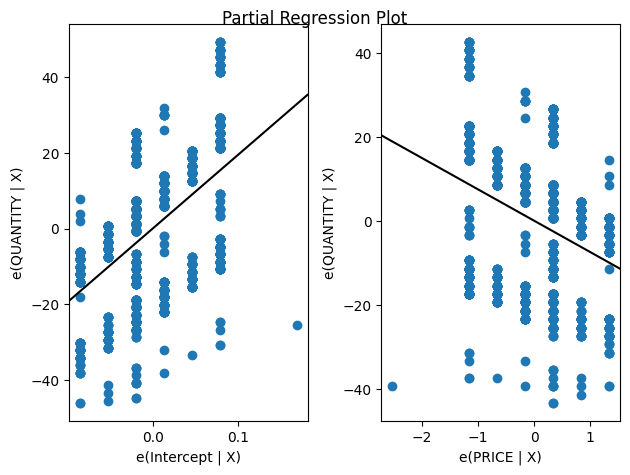

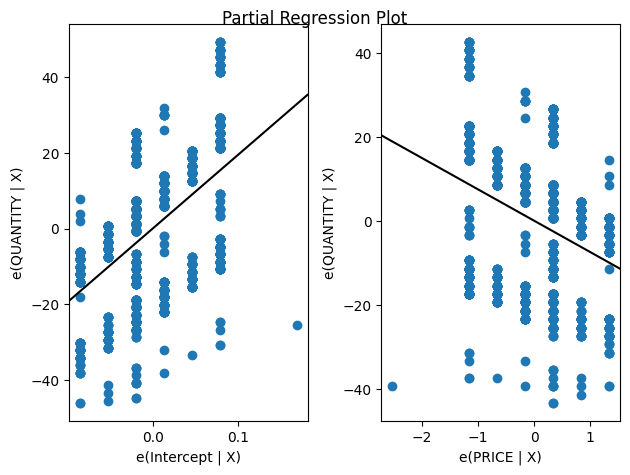

In [15]:
plot_partregress_grid(burger_1070_model)

## Find elasticities for all combinations

In [16]:
model_elasticity = {}

In [17]:
def create_model_and_find_elasticity(data):
    model = ols("QUANTITY ~ PRICE", data).fit()
    price_elasticity = model.params[1]
    return price_elasticity, model

In [18]:
for i, df in cleaned_data.groupby(["SELL_ID", "ITEM_NAME"]):
    e, model = create_model_and_find_elasticity(df)
    model_elasticity[i] = (e, model)

In [19]:
# all elasticities are negative, this is good
model_elasticity

{(1070, 'BURGER'): (-7.478107135366496,
  <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fd4fad3af40>),
 (2051, 'BURGER'): (-1.9128005756803146,
  <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fd4faa1c8e0>),
 (2051, 'COKE'): (-1.9128005756803146,
  <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fd4fae2af40>),
 (2052, 'BURGER'): (-2.271811473474679,
  <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fd4fae32be0>),
 (2052, 'LEMONADE'): (-2.271811473474679,
  <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fd4fae32490>),
 (2053, 'BURGER'): (-5.226102393167906,
  <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fd4fae39490>),
 (2053, 'COFFEE'): (-5.226102393167906,
  <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fd4fae40e20>),
 (2053, 'COKE'): (-5.226102393167906,
  <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fd4fae47850>)}

## Now let's find the optimal price where maximum profit is the highest first, for SELL_ID 1070

In [20]:
burger_1070 = cleaned_data[cleaned_data["SELL_ID"] == 1070]

In [21]:
burger_1070.PRICE.min(), burger_1070.PRICE.max(), burger_1070.COSTS.unique()[0]

(12.64, 16.5, 8.0)

In [22]:
start_price = 8.5
end_price = 25

In [23]:
opt_price_table = pd.DataFrame(columns = ["PRICE", "QUANTITY"])
opt_price_table["PRICE"] = np.arange(start_price, end_price, 0.01)
opt_price_table["QUANTITY"] = model_elasticity[(1070, "BURGER")][1].predict(opt_price_table["PRICE"])
opt_price_table["PROFIT"] = (opt_price_table["PRICE"] - burger_1070.COSTS.unique()[0]) * opt_price_table["QUANTITY"]

<AxesSubplot: xlabel='PRICE'>

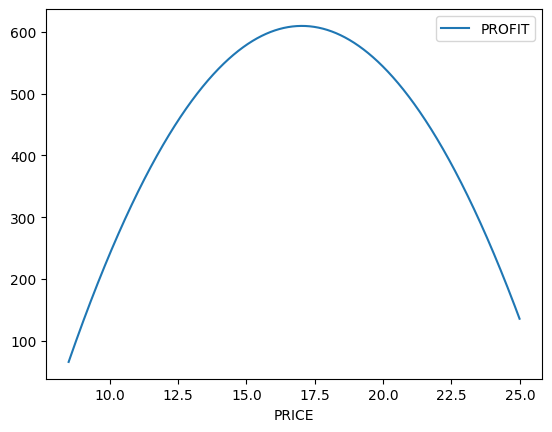

In [24]:
opt_price_table.plot("PRICE", "PROFIT")

In [25]:
# we can see that the optimal price is at 17.03
ind = np.where(opt_price_table["PROFIT"] == opt_price_table["PROFIT"].max())[0][0]
opt_price_table.loc[[ind]]

,PRICE,QUANTITY,PROFIT
853,17.03,67.503598,609.55749


## Find the optimal price for all products

In [26]:
def find_optimal_price(data, model):
    start_price = data["COSTS"].unique()[0] + 0.5
    end_price = data["COSTS"].unique()[0] + 20
    opt_price_table = pd.DataFrame(columns = ["PRICE", "QUANTITY"])
    opt_price_table["PRICE"] = np.arange(start_price, end_price, 0.01)
    opt_price_table["QUANTITY"] = model.predict(opt_price_table["PRICE"])
    opt_price_table["PROFIT"] = (opt_price_table["PRICE"] - data["COSTS"].unique()[0]) * opt_price_table["QUANTITY"]
    ind = np.where(opt_price_table["PROFIT"] == opt_price_table["PROFIT"].max())[0][0]
    opt_price_table["SELL_ID"] = data["SELL_ID"].unique()[0]
    opt_price_table["ITEM_NAME"] =  data["ITEM_NAME"].unique()[0]
    optimal_price = opt_price_table.loc[[ind]]
    optimal_price = optimal_price[["SELL_ID", "ITEM_NAME", "PRICE"]].rename(columns={"PRICE": "ML_PRICE"})
    return optimal_price

In [27]:
optimal_prices = []
for i, df in cleaned_data.groupby(["SELL_ID", "ITEM_NAME"]):
    ml_price = find_optimal_price(df, model_elasticity[i][1])
    optimal_prices.append(ml_price)

In [28]:
optimal_prices_output = pd.concat(optimal_prices)
optimal_prices_output["RUN_TS"] = now = datetime.now()

In [29]:
optimal_prices_output

,SELL_ID,ITEM_NAME,ML_PRICE,RUN_TS
853,1070,BURGER,17.03,2022-10-02 16:42:55.323189
1032,2051,BURGER,16.82,2022-10-02 16:42:55.323189
932,2051,COKE,17.82,2022-10-02 16:42:55.323189
705,2052,BURGER,13.55,2022-10-02 16:42:55.323189
655,2052,LEMONADE,14.05,2022-10-02 16:42:55.323189
638,2053,BURGER,13.88,2022-10-02 16:42:55.323189
613,2053,COFFEE,14.13,2022-10-02 16:42:55.323189
588,2053,COKE,14.38,2022-10-02 16:42:55.323189


## Now export our output to nocode

In [30]:
to_nocode(optimal_prices_output, "optimal_prices_output", configuration, mode="replace_data")

Upload Successful, please wait a moment for the changes to appear
